In [1]:
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

In [3]:
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09',
         '#c79fef', '#80f9ad']

In [4]:
import urllib.request

filepath = "../dataset/"
url = "https://tvml.github.io/ml2021/dataset/"

def get_file(filename,local):
    if local:
        return filepath+filename
    else:
        urllib.request.urlretrieve (url+filename, filename)
        return filename

Legge il dataset

In [5]:
data = io.loadmat(get_file("XwindowsDocData.mat",local=0))

xtrain = data['xtrain']
ytrain = data['ytrain']

ndocs = xtrain.shape[0] 
nterms = xtrain.shape[1]
classes = np.unique(ytrain)
nclasses = classes.shape[0]

In [6]:
print('{} termini'.format(nterms))

600 termini


In [201]:
f = lambda x: x[0]
vocab = np.array(list(map(f, data['vocab'][:,0])))

In [8]:
xtrain.shape

(900, 600)

In [51]:
doc_id = 6
doc = np.argwhere(xtrain[doc_id,:]== 1)[:,1]
#np.argwhere(doc == 1)[:,1]
#np.nonzero(doc)
doc

array([ 23,  85, 106, 118, 179, 218, 225, 245, 274, 351, 432, 444, 509,
       518, 587], dtype=int32)

In [57]:
doc_id = 6
doc = np.argwhere(xtrain[doc_id,:]== 1)[:,1]
print('Documento {1:3d}: {0:2.0f} termini diversi, {2:5.2f}% di tutto il vocabolario'.format(doc.shape[0], doc_id,
                doc.shape[0]/xtrain.shape[1]*100))
print('Id dei termini: {}'.format(doc))

Documento   6: 15 termini diversi,  2.50% di tutto il vocabolario
Id dei termini: [ 23  85 106 118 179 218 225 245 274 351 432 444 509 518 587]


Crea un classificatore Naive-Bayes ed effettua il learning sul dataset

In [58]:
clf = MultinomialNB(alpha=1.0e-9)
clf.fit(xtrain, ytrain.ravel())

MultinomialNB(alpha=1e-09)

Deriva probabilità a priori delle classi $p(C_i)$

In [109]:
prior=np.exp(clf.class_log_prior_)
prior

array([0.5, 0.5])

Deriva probabilità deli termini date le classi (likelihood) $p(t_j|C_i)$

In [111]:
lik=np.exp(clf.feature_log_prob_)
lik.shape

(2, 600)

Deriva probabilità a priori delle feature (evidenza) $p(t_j)=p(t_j|C_1)p(C_1)+p(t_j|C_2)p(C_2)$

In [113]:
evid=np.array([lik[0,i]*prior[0]+lik[1,i]*prior[1] for i in range(lik.shape[1])])
evid.shape

(600,)

In [114]:
k= 20
print('Probabilità dei primi {} termini\n\nA priori: \n{}\n\nCondizionata alla classe 0: \n{}\n\nCondizionata alla classe 1: \n{}'.format(k, evid[:k], lik[0,:k], lik[1,:k]))

Probabilità dei primi 20 termini

A priori: 
[3.88230745e-04 3.04506699e-04 4.71954790e-04 8.37240457e-05
 2.43574766e-04 6.16610769e-04 7.61266749e-05 9.43909581e-04
 4.18620228e-04 4.69660282e-03 1.59850720e-04 2.00953006e-03
 6.24208140e-04 4.64357420e-04 3.95828116e-04 4.03425486e-04
 3.19701441e-04 2.69467013e-03 2.87731297e-03 1.37012718e-03]

Condizionata alla classe 0: 
[1.67448091e-04 1.67448091e-13 3.34896182e-04 1.67448091e-04
 3.34896182e-04 1.67448091e-04 1.67448091e-13 6.69792364e-04
 8.37240456e-04 4.52109846e-03 1.67448091e-04 2.34427328e-03
 3.34896182e-04 1.67448091e-04 3.34896182e-04 5.02344273e-04
 3.34896182e-04 2.34427328e-03 3.01406564e-03 1.67448091e-03]

Condizionata alla classe 1: 
[6.09013398e-04 6.09013398e-04 6.09013398e-04 1.52253350e-13
 1.52253350e-04 1.06577345e-03 1.52253350e-04 1.21802680e-03
 1.52253350e-13 4.87210719e-03 1.52253350e-04 1.67478685e-03
 9.13520098e-04 7.61266748e-04 4.56760049e-04 3.04506699e-04
 3.04506699e-04 3.04506699e-03 2.740560

Applica la regola di Bayes per calcolare le probabilità a posteriori delle classi data l'occorrenza dei termini

$$p(C_k|t_j)=\frac{p(t_j|C_k)p(C_k)}{p(t_j)}$$

In [115]:
post = np.zeros([lik.shape[0],lik.shape[1]])
for i in range(lik.shape[0]):
    for j in range(lik.shape[1]):
        post[i,j] = lik[i,j]*prior[i]/evid[j]

In [116]:
post.shape

(2, 600)

In [122]:
k= 20
print("Probabilità delle due classi condizionata all'occorrenza dei primi {} termini\n\nClasse 0: \n{}\n\nClasse 1: \n{}".format(k, post[0,:k], post[1,:k]))

Probabilità delle due classi condizionata all'occorrenza primi 20 termini

Classe 0: 
[2.15655372e-01 2.74949765e-10 3.54796889e-01 9.99999999e-01
 6.87460749e-01 1.35781030e-01 1.09979906e-09 3.54796889e-01
 1.00000000e+00 4.81315818e-01 5.23763955e-01 5.83288929e-01
 2.68256821e-01 1.80300868e-01 4.23032333e-01 6.22598584e-01
 5.23763955e-01 4.34983348e-01 5.23763955e-01 6.11067694e-01]

Classe 1: 
[7.84344628e-01 1.00000000e+00 6.45203111e-01 9.09257002e-10
 3.12539251e-01 8.64218970e-01 9.99999999e-01 6.45203111e-01
 1.81851401e-10 5.18684182e-01 4.76236045e-01 4.16711071e-01
 7.31743179e-01 8.19699132e-01 5.76967667e-01 3.77401416e-01
 4.76236045e-01 5.65016652e-01 4.76236045e-01 3.88932306e-01]


Applica la regola di Bayes per calcolare le probabilità a posteriori delle classi data la non occorrenza dei termini

$$p(C_k|\lnot t_j)=\frac{p(\lnot t_j|C_k)p(C_k)}{p(\lnot t_j)}=\frac{(1-p(t_j|C_k))p(C_k)}{1-p(t_j)}$$

In [121]:
post_n = np.zeros([lik.shape[0],lik.shape[1]])
for i in range(lik.shape[0]):
    for j in range(lik.shape[1]):
        post_n[i,j] = (1-lik[i,j])*prior[i]/(1-evid[j])

In [123]:
k= 20
print("Probabilità delle due classi condizionata alla non occorrenza dei primi {} termini\n\nClasse 0: \n{}\n\nClasse 1: \n{}".format(k, post[0,:k], post_n[1,:k]))

Probabilità delle due classi condizionata alla non occorrenza dei primi 20 termini

Classe 0: 
[2.15655372e-01 2.74949765e-10 3.54796889e-01 9.99999999e-01
 6.87460749e-01 1.35781030e-01 1.09979906e-09 3.54796889e-01
 1.00000000e+00 4.81315818e-01 5.23763955e-01 5.83288929e-01
 2.68256821e-01 1.80300868e-01 4.23032333e-01 6.22598584e-01
 5.23763955e-01 4.34983348e-01 5.23763955e-01 6.11067694e-01]

Classe 1: 
[0.49988957 0.4998477  0.49993144 0.50004187 0.50004567 0.49977528
 0.49996193 0.49986281 0.5002094  0.49991183 0.5000038  0.50016771
 0.49985525 0.49985148 0.49996952 0.50004948 0.5000076  0.49982433
 0.50006857 0.50015239]


Plot del modello generale di linguaggio, per l'unione delle due classi

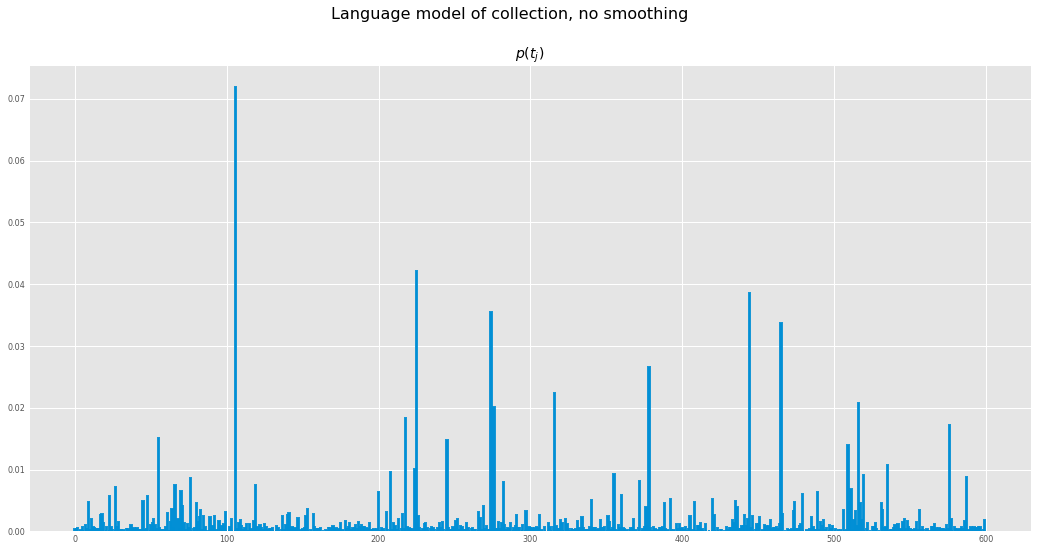

In [118]:
fig=plt.figure(figsize=(16,8))
ax=plt.subplot(1,1,1)
ax.bar(range(clf.feature_count_.shape[1]), evid,  facecolor=colors[0], alpha=0.9, edgecolor=colors[0], lw=2)
plt.title('$p(t_j)$', fontsize=14)
plt.suptitle('Language model of collection, no smoothing ', fontsize=16)
plt.show()

Plot del modello di linguaggio risultante per le due classi

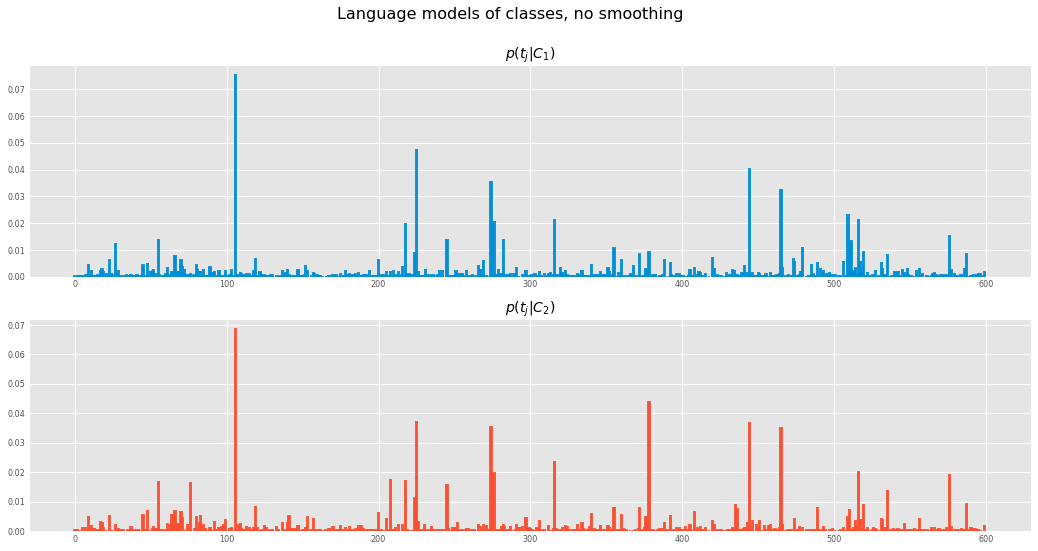

In [119]:
fig=plt.figure(figsize=(16,8))
for i,c in enumerate(classes):
    ax=plt.subplot(nclasses,1,i+1)
    ax.bar(range(clf.feature_count_.shape[1]), lik[i,:],  facecolor=colors[i], alpha=0.9, edgecolor=colors[i], lw=2)
    plt.title('$p(t_j|C_{0:1d})$'.format(c), fontsize=14)
plt.suptitle('Language models of classes, no smoothing ', fontsize=16)
plt.show()

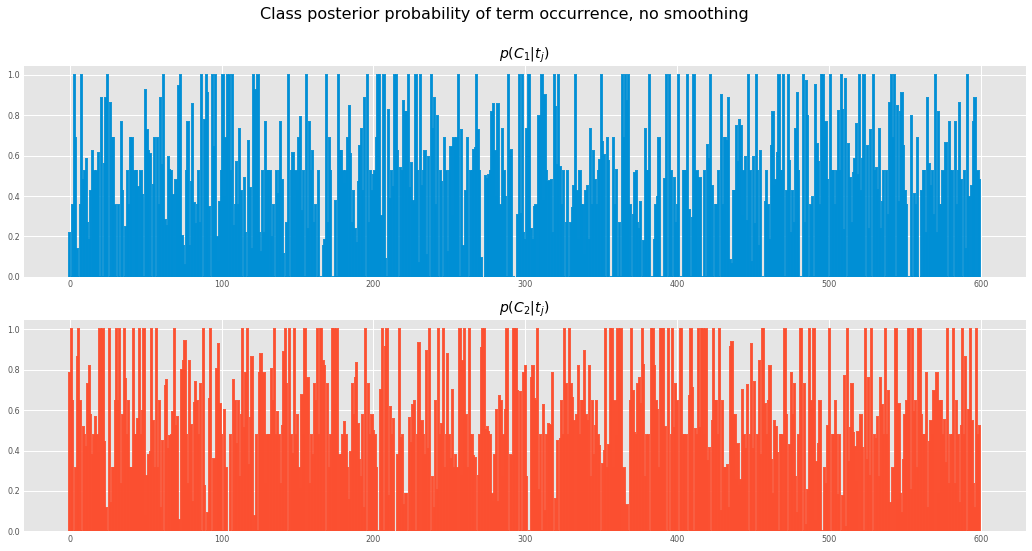

In [124]:
fig=plt.figure(figsize=(16,8))
for i,c in enumerate(classes):
    ax=plt.subplot(nclasses,1,i+1)
    ax.bar(range(clf.feature_count_.shape[1]), post[i,:],  facecolor=colors[i], alpha=0.9, edgecolor=colors[i], lw=2)
    plt.title('$p(C_{0:1d}|t_j)$'.format(c), fontsize=14)
plt.suptitle('Class posterior probability of term occurrence, no smoothing ', fontsize=16)
plt.show()

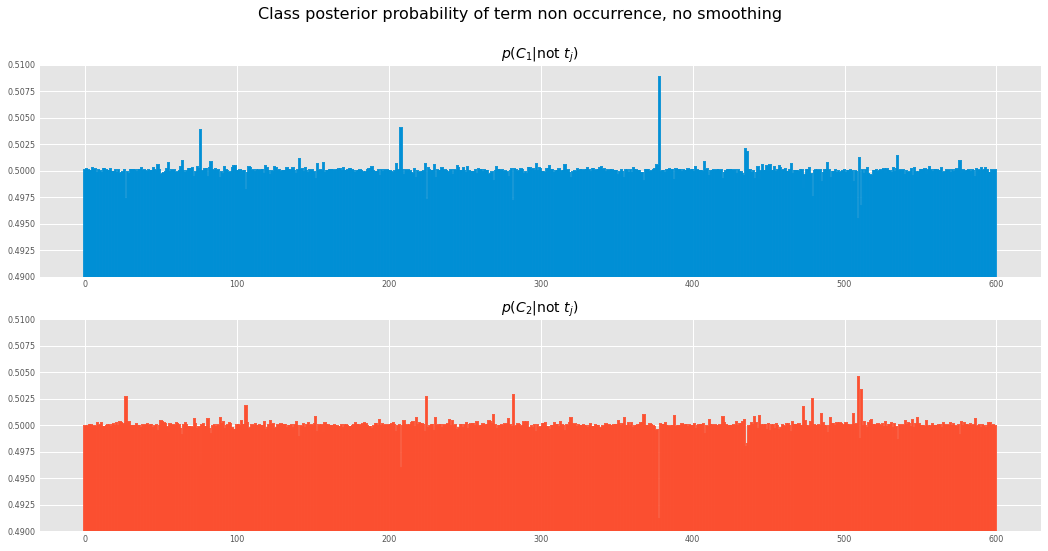

In [137]:
fig=plt.figure(figsize=(16,8))
for i,c in enumerate(classes):
    ax=plt.subplot(nclasses,1,i+1)
    ax.bar(range(clf.feature_count_.shape[1]), post_n[i,:],  facecolor=colors[i], alpha=0.9, edgecolor=colors[i], lw=2)
    plt.ylim([0.49,0.51])
    plt.title(r'$p(C_{0:1d}|$not $ t_j)$'.format(c), fontsize=14)
plt.suptitle('Class posterior probability of term non occurrence, no smoothing ', fontsize=16)
plt.show()

Applicazione del classificatore al training set e derivazione della accuracy

In [93]:
preds = clf.predict(xtrain)
print('Accuracy = {0:8.7f}'.format(accuracy_score(ytrain, preds)))

Accuracy = 0.9211111


Istanza classificatore Naive-Bayes con Dirichlet smoothing simmetrico, con iperparametro $\alpha$ ed effettua il learning sul dataset

In [105]:
α = 50
clf1 = MultinomialNB(alpha=α)
clf1.fit(xtrain, ytrain.ravel())

MultinomialNB(alpha=50)

Deriva probabilità a posteriori delle feature (termini) $p(t_j|C_i)$

In [103]:
pf1=np.exp(clf1.feature_log_prob_)

Plot del modello di linguaggio risultante per le due classi

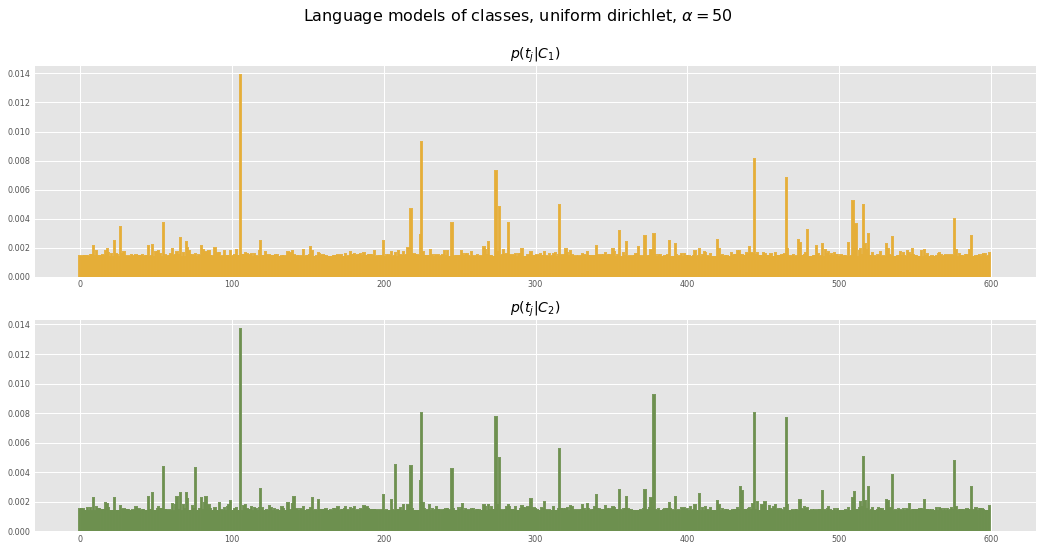

In [106]:
fig=plt.figure(figsize=(16,8))
for i,c in enumerate(classes):
    ax=plt.subplot(nclasses,1,i+1)
    ax.bar(range(clf1.feature_count_.shape[1]), pf1[i,:],  facecolor=colors[i+2], alpha=0.9, edgecolor=colors[i+2], lw=2)
    plt.title('$p(t_j|C_{0:1d})$'.format(c), fontsize=14)
plt.suptitle(r"Language models of classes, uniform dirichlet, $\alpha= {0:2d}$".format(α), fontsize=16)
plt.show()

Applicazione del classificatore al training set e derivazione della accuracy

In [107]:
preds1 = clf1.predict(xtrain)
print('Accuracy = {0:8.7f}'.format(accuracy_score(ytrain, preds1)))

Accuracy = 0.8722222


Definizione della funzione che calcola la mutua informazione di un termine $t$ rispetto alle classi

$$\sum_{C_0,C_1}\sum_{t=0,1} p(C,t)\log\frac{p(C,t)}{p(C)p(t)}=\sum_{C_0,C_1}\sum_{t=0,1} p(t|C)p(C)\log\frac{p(t|C)p(C)}{p(C)p(t)}$$

In [211]:
def mutual_information(term):
    s = 0
    for cl in [0,1]:
        s += lik[cl, term]*prior[cl]*np.log2(lik[cl, term]*prior[cl]/(prior[cl]*evid[term]))
        s += (1-lik[cl, term])*prior[cl]*np.log2((1-lik[cl, term])*prior[cl]/(prior[cl]*(1-evid[term])))
    return s

Calcolo del valore della mutua informazione per ogni termine

In [218]:
mi = np.array([mutual_information(f) for f in range(pf.shape[1])])

In [232]:
mi[378]

0.008958896585017364

Ordinamento decrescente dei termini rispetto alla mutua informazione

In [229]:
ordered_terms = np.flip(np.argsort(mi),0)

In [230]:
vocab[ordered_terms[:10]]

array(['windows', 'microsoft', 'motif', 'dos', 'window', 'sun', 'xterm',
       'code', 'server', 'win'], dtype='<U16')

Plot della mutua informazione dei termini

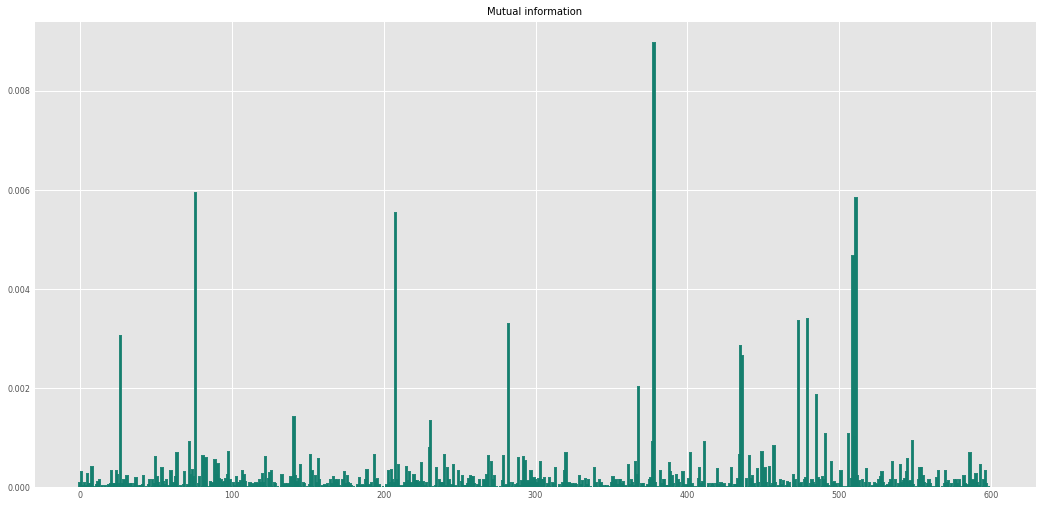

In [233]:
fig=plt.figure(figsize=(16,8))
plt.bar(range(clf1.feature_count_.shape[1]), mi,  facecolor=colors[6], alpha=0.9, edgecolor=colors[6], lw=2)
plt.title(r"Mutual information")
plt.show()

Seleziona i termini più informativi e riduci il training set considerando solo quelli

In [145]:
k = 15

Plot della mutua informazione delle feature selezionate

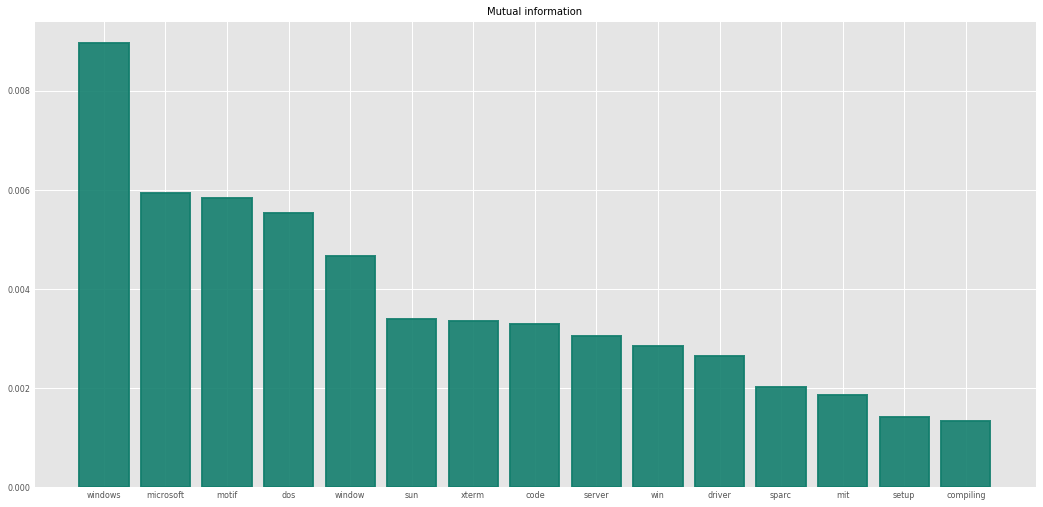

In [238]:
fig=plt.figure(figsize=(16,8))
plt.bar(range(k), mi[ordered_terms[:k]],  facecolor=colors[6], alpha=0.9, edgecolor=colors[6], lw=2)
plt.xticks(range(k), vocab[ordered_terms[:k]])
plt.title(r"Mutual information")
plt.show()

Crea un nuovo classificatore Naive Bayes ed effettua l'apprendimento sul training set ridotto 

In [240]:
x_red = xtrain[:,ordered_terms[:k]]
x_red.shape

(900, 15)

In [241]:
clf2 = MultinomialNB(alpha=1.0e-9)
clf2.fit(x_red, ytrain.ravel())

MultinomialNB(alpha=1e-09)

Applicazione del classificatore al training set ridotto e derivazione della accuracy

In [242]:
preds2 = clf2.predict(x_red)
print('Accuracy = {0:8.7f}'.format(accuracy_score(ytrain, preds2)))

Accuracy = 0.8777778
